In [81]:
# ============================================================================
# IMPORT LIBRARY
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [82]:
# ============================================================================
# LOAD DATASET (UNLABELED)
# ============================================================================

df = pd.read_csv("training_data_clean.csv")

print("Ukuran dataset:", df.shape)
print("\nMissing value:")
print(df.isnull().sum())

df.head()


Ukuran dataset: (2398, 18)

Missing value:
age                0
weight             0
bmi                0
activity           0
goal               0
gender             0
meal_type          0
meal_cal_target    0
meal_budget        0
food_calories      0
food_protein       0
food_carbs         0
food_fat           0
food_price         0
protein_ratio      0
carb_ratio         0
fat_ratio          0
label              0
dtype: int64


,age,weight,bmi,activity,goal,gender,meal_type,meal_cal_target,meal_budget,food_calories,food_protein,food_carbs,food_fat,food_price,protein_ratio,carb_ratio,fat_ratio,label
0,42,62,22.8,2,maintain,F,breakfast,440.085938,15000.0,403.0,24.90,1.28,33.14,2400,0.0618,0.0032,0.0822,1
1,25,55,21.5,2,maintain,F,lunch,608.300000,16800.0,587.0,24.62,71.75,26.57,7500,0.0419,0.1222,0.0453,1
2,38,65,23.0,3,maintain,F,dinner,627.285000,19500.0,42.0,2.80,7.55,0.20,1800,0.0667,0.1798,0.0048,0
3,51,90,30.1,1,lose,M,snack,157.750000,7500.0,597.0,22.09,19.29,52.83,4500,0.0370,0.0323,0.0885,0
4,46,75,26.6,2,lose,F,breakfast,359.343750,17500.0,160.0,2.00,8.53,14.66,4000,0.0125,0.0533,0.0916,0


In [83]:
# ============================================================================
# ENCODING (MENYESUAIKAN DATASET AWAL)
# ============================================================================

# Gender
df["gender_M"] = (df["gender"] == "M").astype(int)
df["gender_F"] = (df["gender"] == "F").astype(int)

# Goal
df["goal_lose"] = (df["goal"] == "lose").astype(int)
df["goal_gain"] = (df["goal"] == "gain").astype(int)
df["goal_maintain"] = (df["goal"] == "maintain").astype(int)

# Meal type
df["meal_breakfast"] = (df["meal_type"] == "breakfast").astype(int)
df["meal_lunch"] = (df["meal_type"] == "lunch").astype(int)
df["meal_dinner"] = (df["meal_type"] == "dinner").astype(int)
df["meal_snack"] = (df["meal_type"] == "snack").astype(int)

df.head()

,age,weight,bmi,activity,goal,gender,meal_type,meal_cal_target,meal_budget,food_calories,...,label,gender_M,gender_F,goal_lose,goal_gain,goal_maintain,meal_breakfast,meal_lunch,meal_dinner,meal_snack
0,42,62,22.8,2,maintain,F,breakfast,440.085938,15000.0,403.0,...,1,0,1,0,0,1,1,0,0,0
1,25,55,21.5,2,maintain,F,lunch,608.300000,16800.0,587.0,...,1,0,1,0,0,1,0,1,0,0
2,38,65,23.0,3,maintain,F,dinner,627.285000,19500.0,42.0,...,0,0,1,0,0,1,0,0,1,0
3,51,90,30.1,1,lose,M,snack,157.750000,7500.0,597.0,...,0,1,0,1,0,0,0,0,0,1
4,46,75,26.6,2,lose,F,breakfast,359.343750,17500.0,160.0,...,0,0,1,1,0,0,1,0,0,0


In [84]:
# ============================================================================
# FEATURE ENGINEERING (SAMA SEPERTI DATASET AWAL)
# ============================================================================

df["protein_ratio"] = df["food_protein"] / df["food_calories"]
df["carb_ratio"] = df["food_carbs"] / df["food_calories"]
df["fat_ratio"] = df["food_fat"] / df["food_calories"]

df["cal_diff_pct"] = abs(df["food_calories"] - df["meal_cal_target"]) / df["meal_cal_target"] * 100
df["price_affordable"] = (df["food_price"] <= df["meal_budget"]).astype(int)

df["goal_aligned"] = np.where(
    ((df["goal"] == "lose") & (df["food_calories"] <= df["meal_cal_target"])) |
    ((df["goal"] == "gain") & (df["food_calories"] >= df["meal_cal_target"])) |
    (df["goal"] == "maintain"),
    1,
    0
)

df["cal_match_25pct"] = (df["cal_diff_pct"] <= 25).astype(int)

df.head()

,age,weight,bmi,activity,goal,gender,meal_type,meal_cal_target,meal_budget,food_calories,...,goal_gain,goal_maintain,meal_breakfast,meal_lunch,meal_dinner,meal_snack,cal_diff_pct,price_affordable,goal_aligned,cal_match_25pct
0,42,62,22.8,2,maintain,F,breakfast,440.085938,15000.0,403.0,...,0,1,1,0,0,0,8.426976,1,1,1
1,25,55,21.5,2,maintain,F,lunch,608.300000,16800.0,587.0,...,0,1,0,1,0,0,3.501562,1,1,1
2,38,65,23.0,3,maintain,F,dinner,627.285000,19500.0,42.0,...,0,1,0,0,1,0,93.304479,1,1,0
3,51,90,30.1,1,lose,M,snack,157.750000,7500.0,597.0,...,0,0,0,0,0,1,278.446910,1,0,0
4,46,75,26.6,2,lose,F,breakfast,359.343750,17500.0,160.0,...,0,0,1,0,0,0,55.474389,1,1,0


In [85]:
# ============================================================================
# DROP KOLOM RAW
# ============================================================================

df = df.drop(columns=["gender", "goal", "meal_type"])
df.head()

,age,weight,bmi,activity,meal_cal_target,meal_budget,food_calories,food_protein,food_carbs,food_fat,...,goal_gain,goal_maintain,meal_breakfast,meal_lunch,meal_dinner,meal_snack,cal_diff_pct,price_affordable,goal_aligned,cal_match_25pct
0,42,62,22.8,2,440.085938,15000.0,403.0,24.90,1.28,33.14,...,0,1,1,0,0,0,8.426976,1,1,1
1,25,55,21.5,2,608.300000,16800.0,587.0,24.62,71.75,26.57,...,0,1,0,1,0,0,3.501562,1,1,1
2,38,65,23.0,3,627.285000,19500.0,42.0,2.80,7.55,0.20,...,0,1,0,0,1,0,93.304479,1,1,0
3,51,90,30.1,1,157.750000,7500.0,597.0,22.09,19.29,52.83,...,0,0,0,0,0,1,278.446910,1,0,0
4,46,75,26.6,2,359.343750,17500.0,160.0,2.00,8.53,14.66,...,0,0,1,0,0,0,55.474389,1,1,0


In [86]:
# ============================================================================
# AUTO LABELING (RULE-BASED)
# ============================================================================

df["label"] = np.where(
    (df["cal_diff_pct"] <= 25) &
    (df["goal_aligned"] == 1) &
    (df["price_affordable"] == 1),
    1,
    0
)

print("\nDistribusi label:")
print(df["label"].value_counts())
df.head()


Distribusi label:
label
0    2044
1     354
Name: count, dtype: int64


,age,weight,bmi,activity,meal_cal_target,meal_budget,food_calories,food_protein,food_carbs,food_fat,...,goal_gain,goal_maintain,meal_breakfast,meal_lunch,meal_dinner,meal_snack,cal_diff_pct,price_affordable,goal_aligned,cal_match_25pct
0,42,62,22.8,2,440.085938,15000.0,403.0,24.90,1.28,33.14,...,0,1,1,0,0,0,8.426976,1,1,1
1,25,55,21.5,2,608.300000,16800.0,587.0,24.62,71.75,26.57,...,0,1,0,1,0,0,3.501562,1,1,1
2,38,65,23.0,3,627.285000,19500.0,42.0,2.80,7.55,0.20,...,0,1,0,0,1,0,93.304479,1,1,0
3,51,90,30.1,1,157.750000,7500.0,597.0,22.09,19.29,52.83,...,0,0,0,0,0,1,278.446910,1,0,0
4,46,75,26.6,2,359.343750,17500.0,160.0,2.00,8.53,14.66,...,0,0,1,0,0,0,55.474389,1,1,0


In [87]:
leakage_features = [
    "cal_diff_pct",
    "price_affordable",
    "goal_aligned",
    "cal_match_25pct"
]

X = df.drop(columns=["label"] + leakage_features)
y = df["label"]

print("Kolom training:")
print(X.columns.tolist())

X.head()


Kolom training:
['age', 'weight', 'bmi', 'activity', 'meal_cal_target', 'meal_budget', 'food_calories', 'food_protein', 'food_carbs', 'food_fat', 'food_price', 'protein_ratio', 'carb_ratio', 'fat_ratio', 'gender_M', 'gender_F', 'goal_lose', 'goal_gain', 'goal_maintain', 'meal_breakfast', 'meal_lunch', 'meal_dinner', 'meal_snack']


,age,weight,bmi,activity,meal_cal_target,meal_budget,food_calories,food_protein,food_carbs,food_fat,...,fat_ratio,gender_M,gender_F,goal_lose,goal_gain,goal_maintain,meal_breakfast,meal_lunch,meal_dinner,meal_snack
0,42,62,22.8,2,440.085938,15000.0,403.0,24.90,1.28,33.14,...,0.082233,0,1,0,0,1,1,0,0,0
1,25,55,21.5,2,608.300000,16800.0,587.0,24.62,71.75,26.57,...,0.045264,0,1,0,0,1,0,1,0,0
2,38,65,23.0,3,627.285000,19500.0,42.0,2.80,7.55,0.20,...,0.004762,0,1,0,0,1,0,0,1,0
3,51,90,30.1,1,157.750000,7500.0,597.0,22.09,19.29,52.83,...,0.088492,1,0,1,0,0,0,0,0,1
4,46,75,26.6,2,359.343750,17500.0,160.0,2.00,8.53,14.66,...,0.091625,0,1,1,0,0,1,0,0,0


In [88]:
# ============================================================================
# TRAIN - TEST SPLIT
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nJumlah data total :", len(X))
print("Jumlah data latih :", len(X_train))
print("Jumlah data test  :", len(X_test))


Jumlah data total : 2398
Jumlah data latih : 1918
Jumlah data test  : 480


In [89]:
# ============================================================================
# BASELINE RANDOM FOREST
# ============================================================================

baseline_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [90]:

# ============================================================================
# EVALUASI BASELINE
# ============================================================================

y_pred_baseline = baseline_model.predict(X_test)

print("\n=== Baseline Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))


=== Baseline Evaluation ===
Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       409
           1       0.83      0.83      0.83        71

    accuracy                           0.95       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.95      0.95      0.95       480



In [91]:
# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [92]:
# ============================================================================
# EVALUASI MODEL TERBAIK
# ============================================================================

y_pred_best = best_model.predict(X_test)

print("\n=== Tuned Model Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))



=== Tuned Model Evaluation ===
Accuracy: 0.9520833333333333
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       409
           1       0.84      0.83      0.84        71

    accuracy                           0.95       480
   macro avg       0.91      0.90      0.90       480
weighted avg       0.95      0.95      0.95       480



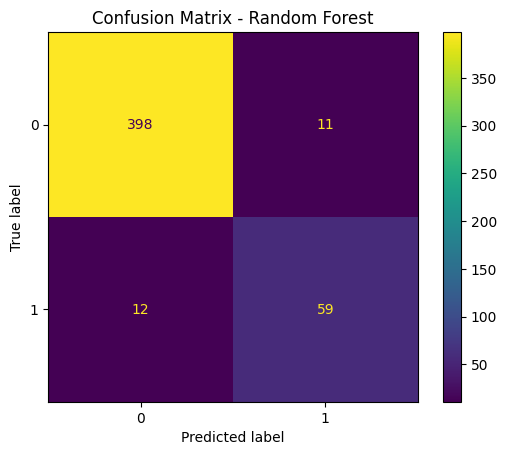

In [93]:
# ============================================================================
# CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [94]:
# ============================================================================
# CROSS VALIDATION
# ============================================================================

cv_scores = cross_val_score(
    best_model,
    X,
    y,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

print("\nCV F1-score per fold:", cv_scores)
print("Mean CV F1-score:", cv_scores.mean())


CV F1-score per fold: [0.8125     0.7761194  0.79136691 0.83453237 0.82962963]
Mean CV F1-score: 0.8088296626380489


In [95]:
# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

importances = best_model.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df.head(10)



,feature,importance
4,meal_cal_target,0.153337
6,food_calories,0.106341
9,food_fat,0.077113
8,food_carbs,0.071573
5,meal_budget,0.060642
7,food_protein,0.059842
2,bmi,0.056432
13,fat_ratio,0.052945
1,weight,0.047942
11,protein_ratio,0.047228


In [96]:
# ============================================================================
# SIMPAN MODEL (JOBLIB & PICKLE)
# ============================================================================

joblib.dump(best_model, "random_forest_model.joblib")

with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

df.to_csv("training_data_labeled.csv", index=False)

print("\nModel berhasil disimpan:")
print("- random_forest_model.joblib")
print("- random_forest_model.pkl")
print("Dataset berlabel disimpan: training_data_labeled.csv")


Model berhasil disimpan:
- random_forest_model.joblib
- random_forest_model.pkl
Dataset berlabel disimpan: training_data_labeled.csv
